<a href="https://colab.research.google.com/github/Greta-gerasimov/PyT/blob/L10_Project/L10_gcm_PyT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install facenet-pytorch==2.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from glob import glob
import sys, os

from sklearn.model_selection import train_test_split

# import PIL
from PIL import Image
import matplotlib.pyplot as plt
# import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ColabNotebooks/Project23/WEB_recog.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [9]:
images = glob('leapGestRecog/**/**/*.png')

In [10]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images]

images[:3], labels[:3], len(images), len(labels)

(['leapGestRecog/01/02_l/frame_01_02_0178.png',
  'leapGestRecog/01/02_l/frame_01_02_0131.png',
  'leapGestRecog/01/02_l/frame_01_02_0026.png'],
 [1, 1, 1],
 20000,
 20000)

In [12]:
num_name_list = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
num_name_dict = {}
for num, name in num_name_list:
    if num not in num_name_dict.keys():
        num_name_dict[num] = name

sorted(num_name_dict.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [13]:
def num_to_classname(num):

    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [14]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

(240, 640)


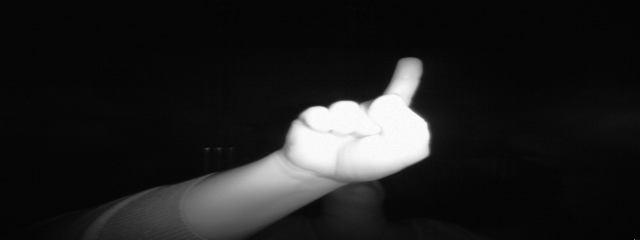

In [15]:
img = Image.open(images[4563])
print(np.array(img).shape)
img

In [16]:
# Transform train & test data

train_tfms = transforms.Compose([
                         transforms.Grayscale(num_output_channels=1), # Картинки черно-белые - переводим чтобы была 1-канальность1
                         transforms.Resize((48,48)),
                         transforms.RandomHorizontalFlip(), # Случайные повороты на 90 градусов
                         transforms.RandomRotation(30), # Случайные повороты на 30 градусов
                         transforms.ToTensor()]) # Приведение к тензору
                         # это на обучение чтобы сделать побольше данный и аугмиентацию

test_tfms =  transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()])
                         # а для теста тольуо перевод в чб и в тензор переводим

In [17]:
class GestRecogDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx])
        img = self.transformer(img)

        return img, self.labels[idx]

In [18]:
batch_size = 256

# Create datasets
train_dataset = GestRecogDataset(X_train, y_train, train_tfms)
test_dataset = GestRecogDataset(X_test, y_test, test_tfms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

Класс: 0 - palm
torch.Size([1, 48, 48])


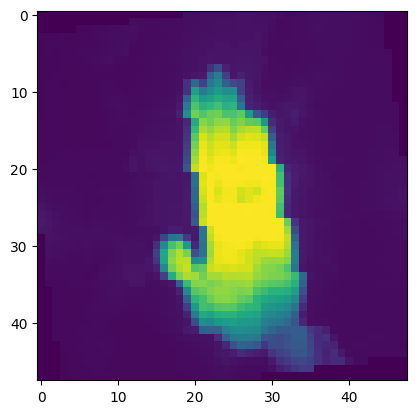

Класс: 7 - palm_moved
torch.Size([1, 48, 48])


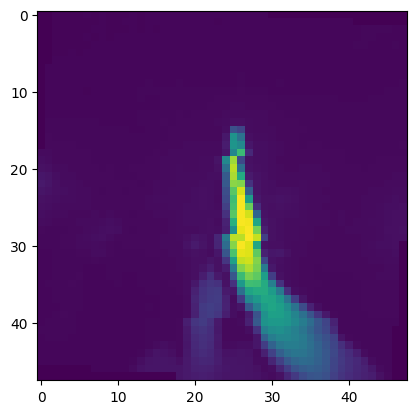

Класс: 9 - down
torch.Size([1, 48, 48])


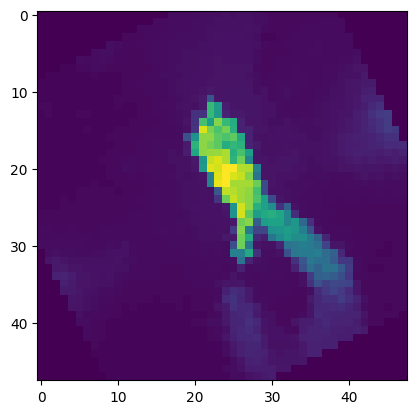

In [19]:
for i, data in enumerate(train_loader):
    print(f'Класс: {data[1][i]} - {num_to_classname(data[1][i])}')
    print(data[0][i].shape)
    plt.imshow(data[0][i].permute(1,2,0).squeeze())
    plt.show()
    if i==2:
        break

image: torch.Size([1, 48, 48])


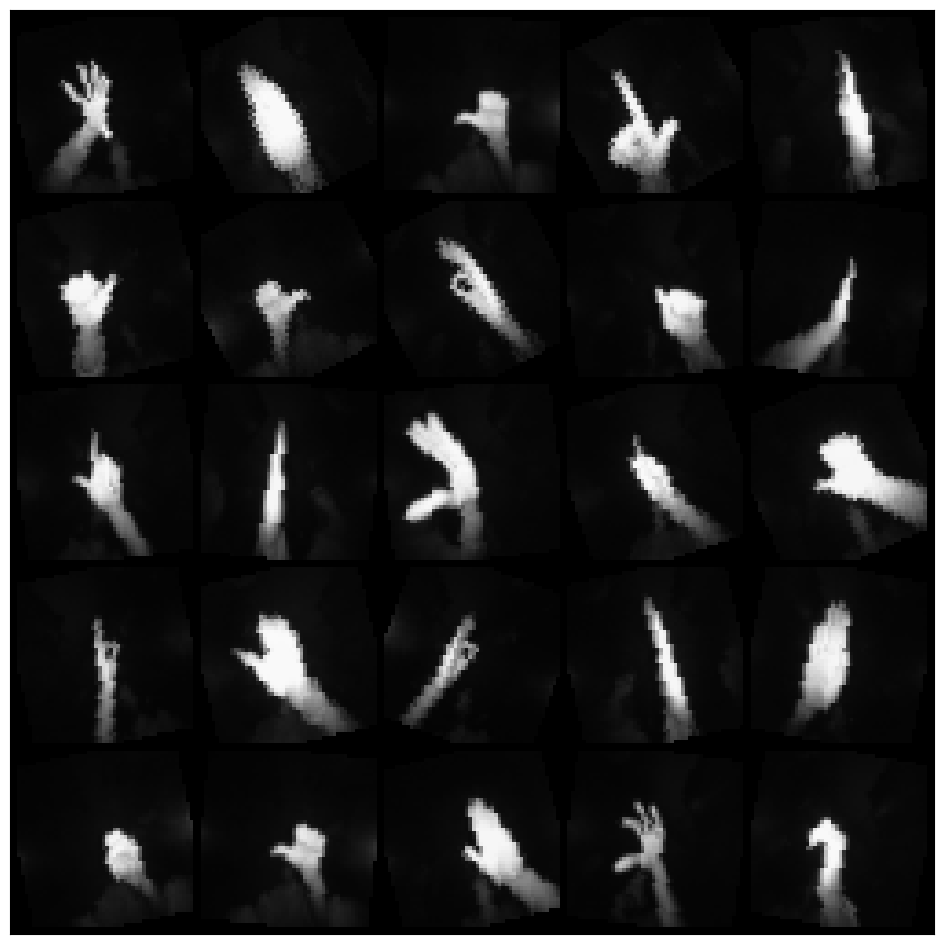

In [20]:
def show_batch(train_loader):

    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(f'image: {images[0].shape}')
        ax.imshow(make_grid(images[:25], nrow=5).permute(1, 2, 0))
        break

show_batch(train_loader)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):

    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.classifier(out)
        return out

In [23]:
model = ResNet(1, len(num_name_dict)).to(device)

In [24]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [25]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

Real gesture: (7, 'palm_moved'), Predicted gesture: (0, 'palm')


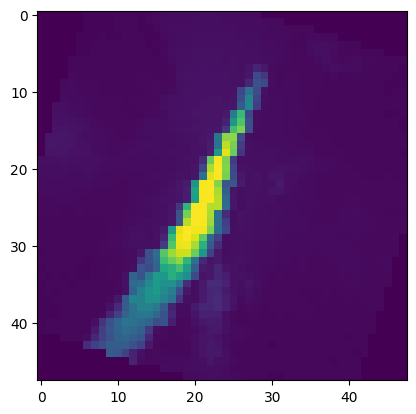

In [26]:
for i, (img, label) in enumerate(train_loader):
    output = model(img[i][None].to(device))
    print(f'Real gesture: {int(label[i]), num_to_classname(int(label[i]))}, '
          f'Predicted gesture: {int(output.argmax(1)), num_to_classname(int(output.argmax(1)))}')
    plt.imshow(img[i].permute(1,2,0).squeeze())
    break

In [27]:
epochs = 10

epoch_losses = []

for epoch in range(epochs):

    train_running_loss = 0.0
    total_acc_train = 0.0
    epoch_loss = []
    for data, labels in tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, labels)

        train_running_loss += loss.item()
        epoch_loss.append(loss.item())

        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_train += acc

        loss.backward()
        optimizer.step()


    test_running_loss, total_acc_test = 0.0, 0.0
    test_epoch_loss = []
    for data, labels in test_loader:
        model.eval()
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())

        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_test += acc

    print(f'Epoch {epoch+1}, loss:, {np.mean(epoch_loss)}, Train acc:, {total_acc_train / len(train_dataset):.3f}  '
          f'Test loss:, {np.mean(test_epoch_loss)}, Test acc: {total_acc_test / len(test_dataset):.3f}')
    epoch_losses.append(epoch_loss)

100%|██████████| 58/58 [01:02<00:00,  1.09s/it]


Epoch 1, loss:, 6.993048639133058, Train acc:, 0.132  Test loss:, 3.28711816072464, Test acc: 0.098


100%|██████████| 58/58 [00:49<00:00,  1.18it/s]


Epoch 2, loss:, 2.2880751552252936, Train acc:, 0.141  Test loss:, 2.024822562932968, Test acc: 0.230


100%|██████████| 58/58 [00:47<00:00,  1.22it/s]


Epoch 3, loss:, 1.9453166702698017, Train acc:, 0.279  Test loss:, 1.8155819177627563, Test acc: 0.346


100%|██████████| 58/58 [00:47<00:00,  1.21it/s]


Epoch 4, loss:, 1.6782586903407657, Train acc:, 0.412  Test loss:, 2.084981471300125, Test acc: 0.324


100%|██████████| 58/58 [00:48<00:00,  1.19it/s]


Epoch 5, loss:, 1.494712620973587, Train acc:, 0.482  Test loss:, 0.8768888086080551, Test acc: 0.709


100%|██████████| 58/58 [00:47<00:00,  1.22it/s]


Epoch 6, loss:, 0.8240707763310137, Train acc:, 0.693  Test loss:, 0.5742993518710137, Test acc: 0.806


100%|██████████| 58/58 [00:50<00:00,  1.14it/s]


Epoch 7, loss:, 0.5169802431402535, Train acc:, 0.798  Test loss:, 0.3894392803311348, Test acc: 0.845


100%|██████████| 58/58 [00:49<00:00,  1.17it/s]


Epoch 8, loss:, 0.3829349071301263, Train acc:, 0.850  Test loss:, 0.24701975882053376, Test acc: 0.905


100%|██████████| 58/58 [00:50<00:00,  1.14it/s]


Epoch 9, loss:, 0.28137459862848807, Train acc:, 0.888  Test loss:, 0.1337660226970911, Test acc: 0.966


100%|██████████| 58/58 [00:49<00:00,  1.17it/s]


Epoch 10, loss:, 0.16316232303607053, Train acc:, 0.934  Test loss:, 0.09475550055503845, Test acc: 0.967


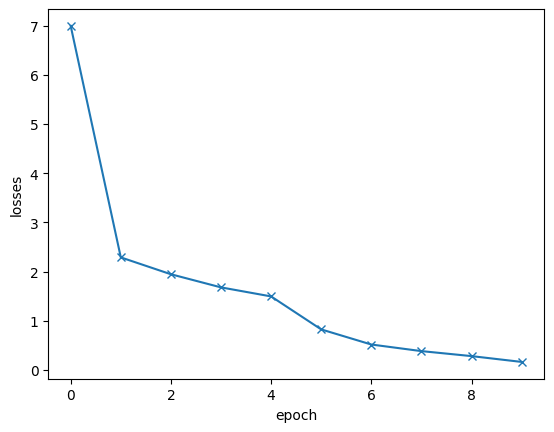

In [28]:
# Plot loss

losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [29]:
# Save model

model_path = './gesture_classification_model.pth'
torch.save(model, model_path)

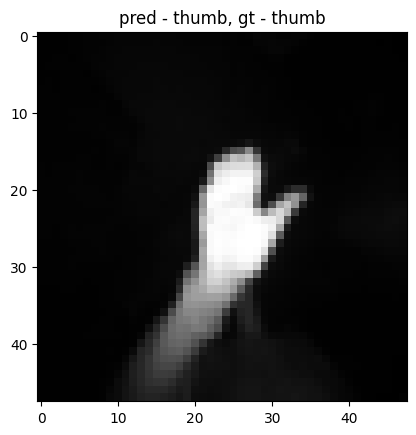

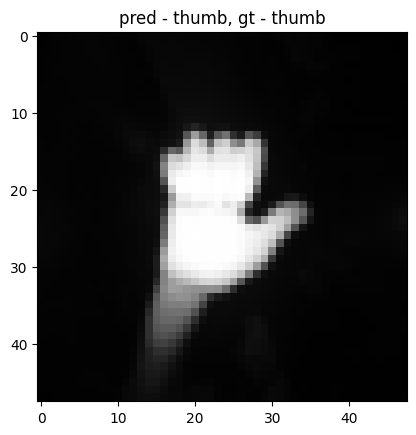

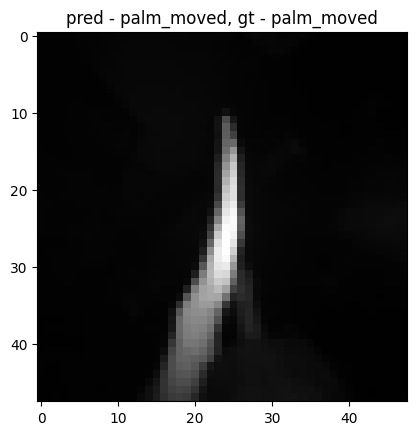

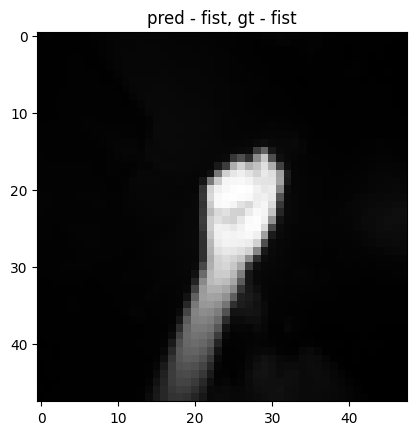

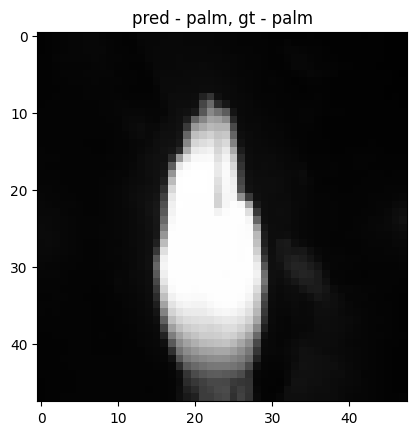

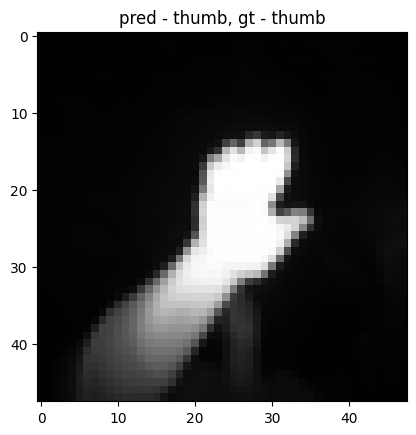

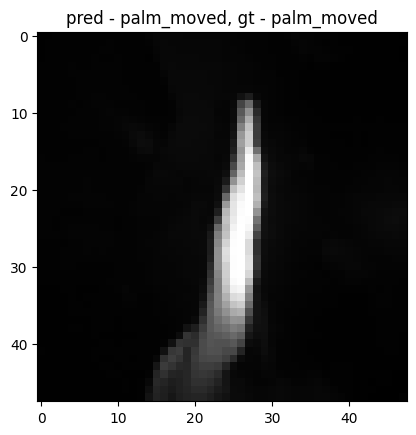

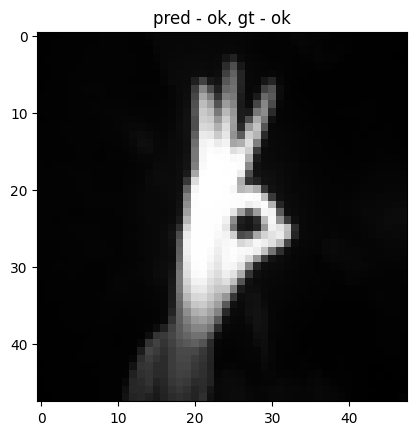

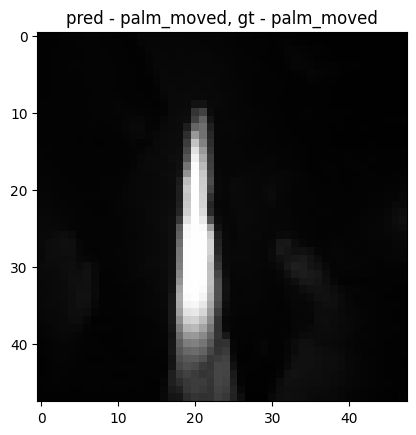

In [30]:
# Load model

model = torch.load(model_path)
with torch.no_grad():
    for i, data in enumerate(test_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break